In [1]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
import numpy as np

/home/catj/miniforge3/envs/rxt-dev/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df = pd.read_parquet("../data/processed/CHEMBL240_dataset.pq")

In [3]:
df

,smiles,standard type,standard relation,pchembl value,comment,target chembl id,document year
index,,,,,,,
0,Cc1nc2cc(-n3ncc(C(=O)c4cc5ccc(S(C)(=O)=O)cc5[n...,IC50,'>',NaN,None,CHEMBL240,2016.0
1,Cc1ncc(OC[C@@]2(c3ccc(F)c(F)c3)C[C@H]2C(=O)Nc2...,IC50,'=',5.66,None,CHEMBL240,2015.0
2,O=S(=O)(NCCCCN1CCN(c2nsc3ccccc23)CC1)c1ccc2cc(...,Inhibition,'=',NaN,None,CHEMBL240,2014.0
3,O=S(=O)(NCCCCN1CCN(c2noc3ccccc23)CC1)c1ccc(OC(...,Inhibition,'=',NaN,None,CHEMBL240,2014.0
4,O=S(=O)(NCCCN1CCN(c2noc3ccccc23)CC1)c1cccs1,Inhibition,'=',NaN,None,CHEMBL240,2014.0
...,...,...,...,...,...,...,...
25223,NCCCCN(C[C@H]1Cc2ccccc2CN1)[C@H]1CCCc2cccnc21,IC50,'=',5.05,None,CHEMBL240,2018.0
25224,CN(C[C@H]1Cc2c(cccc2N2CCNCC2)CN1)[C@H]1CCCc2cc...,IC50,'=',4.69,None,CHEMBL240,2018.0
25225,N#Cc1cccc2c1C=Cc1ncc(-c3ccccc3)cc1C2O,IP,'=',NaN,None,CHEMBL240,2009.0


In [4]:
df["pchembl value"].isna().sum()

11292

In [5]:
# df[df["pchembl value"].isna()]
# df["smiles"].__len__()
dummy_pchembl_value = 3.99
df = df.set_index("smiles")
numery = df["pchembl value"].groupby("smiles").mean().dropna()
comments = df[(df["comment"].str.contains("Not Active") == True)]
inhibits = df[(df["standard type"] == "Inhibition") & df["standard relation"].isin(["<", "<="])]
relations = df[
    df["standard type"].isin(["EC50", "IC50", "Kd", "Ki"])
    & df["standard relation"].isin([">", ">="])
]
binary = pd.concat([comments, inhibits, relations], axis=0)
binary = binary[~binary.index.isin(numery.index)]
binary["pchembl value"] = dummy_pchembl_value
binary = binary["pchembl value"].groupby(binary.index).first()
new_values = pd.concat([numery, binary])
new_values

smiles
Br.CCn1c(O)c(N=NC2=NC(=O)CS2)c2ccccc21               5.32
Br.CN1[C@H]2CC[C@@H]1C[C@H](OC(=O)C(O)c1ccccc1)C2    3.99
Brc1c(NC2=NCCN2)ccc2nccnc12                          3.99
Brc1ccc(Nc2ccc(CN3CCC4(CC3)OCCc3sccc34)cc2)cc1       5.37
Brc1ccc2c(NC3=NC[C@@]4(CN5CCC4CC5)O3)ncnn12          5.60
                                                     ... 
c1coc(-c2ccc(OCCCN3CCCCC3)cc2)c1                     7.05
c1csc(-c2ccc(OCCCN3CCCCC3)cc2)c1                     7.85
c1ncc(-c2cc3sc(N4CCC(N5CCCCC5)CC4)nc3cn2)cn1         5.19
c1ncc(-c2ccc(OCCCN3CCCCC3)cc2)o1                     5.92
c1ncc(-c2cnc3nc(N4CCC(N5CCCCC5)CC4)sc3c2)cn1         4.63
Name: pchembl value, Length: 9850, dtype: float64

In [6]:
ts_set = df[df["document year"] > 2015]#.dropna(subset=["pchembl value"])

In [10]:
train_set["pchembl value"].isna().sum()

NameError: name 'train_set' is not defined

In [9]:
import seaborn as sns

In [8]:
sns.histplot(ts_set["pchembl value"])

NameError: name 'sns' is not defined

In [18]:
train_set = df[df["document year"] <= 2015].dropna(subset=["pchembl value"])

<AxesSubplot:xlabel='pchembl value', ylabel='Count'>

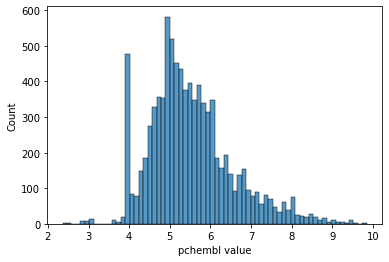

In [20]:
sns.histplot(train_set["pchembl value"])

In [11]:
from rxitect.chem.utils import calc_fp

In [12]:
X_train, y_train = calc_fp(train_set["smiles"], accept_smiles=True), train_set["pchembl value"]

NameError: name 'train_set' is not defined

In [13]:
rf = RandomForestRegressor(n_jobs=-1, max_features=0.33)

In [14]:
rf.fit(X_train, y_train, sample_weight=[1 if v>=4.0 else 0.1 for v in y_train])

NameError: name 'X_train' is not defined

In [15]:
X_test, y_test = calc_fp(ts_set["smiles"], accept_smiles=True), ts_set["pchembl value"]

KeyError: 'smiles'

In [ ]:
y_test.min()

In [ ]:
preds = rf.predict(X_test)

In [16]:
sns.scatterplot(x=y_test, y=preds)

NameError: name 'y_test' is not defined

In [17]:
df['smiles']

KeyError: 'smiles'

In [18]:
import selfies as sf

In [19]:
stoi = {x:i for i,x in enumerate(sf.get_alphabet_from_selfies([sf.encoder(df['smiles'][0])]), start=2)}
stoi['[nop]'] = 0
stoi['.'] = 1

ohe = sf.selfies_to_encoding(sf.encoder(df['smiles'][0]), enc_type='one_hot', pad_to_len=128, vocab_stoi=stoi)

KeyError: 'smiles'

In [94]:
np.count_nonzero(ohe)

128

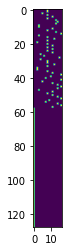

In [95]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(ohe)

In [103]:
count = 0
for i in range(128):
    if ohe[i][0] == 1:
        count += 1
count    

70

In [98]:
from rdkit import Chem
Chem.MolFromSmiles(df["smiles"][0])

In [ ]:
def one_hot_len_without_padding(one_hot: np.ndarray, padding_idx: int = 0) -> int:
    count = 0
    for row in range(len(one_hot)):
        if one_hot[row][padding_idx] == 0:
            count += 1
    return count